<a href="https://colab.research.google.com/github/Colsai/scott_data606/blob/main/topic_modeling/Topic_Modeling_Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HHS OIG Workplan Topic Modeling
## Initial Test of LDA Modeling
*Description: A look through the current OIG work projects and group them using LDA.*

## Specific Questions on Work Plan Projects
1) What does OIG cite as major focus areas (as topics)?  
- *How can we group OIG's work projects and products by topic?*

2) Do those topics line up with major focus areas that HHS OIG designates as their priority outcomes/ultimate goals? (from: https://oig.hhs.gov/documents/root/7/OIG-Strategic-Plan-2020-2025.pdf)


*HHS OIG: Outlined Goals and Priorities*
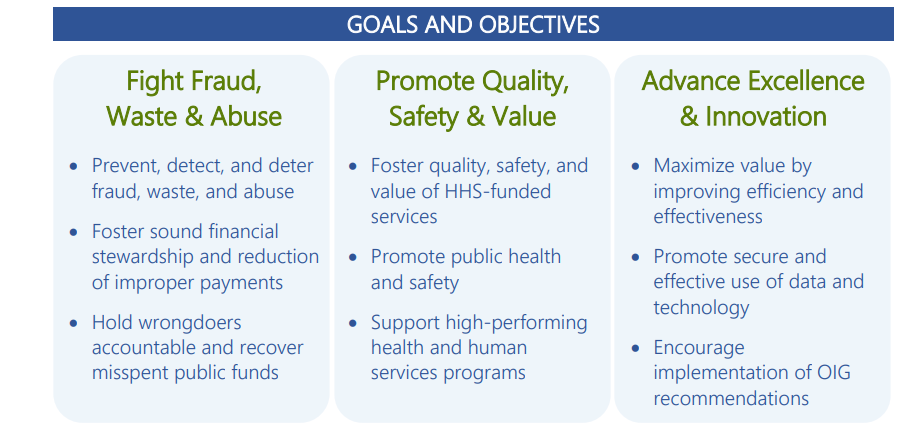

## Topic Models Used:
1) **Latent Dirichilet Allocation (LDA) Model**  
2) **BerTopic Model**


In [1]:
from IPython.display import clear_output

In [2]:
#Install missing packages
!pip install pyLDAvis
!pip install bertopic
!pip install bertopic[visualization]
!python -m spacy download en_core_web_md -qq
clear_output()

In [3]:
###########################
# Import Packages         #
###########################
import pandas as pd
import sklearn
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models
import en_core_web_md
import gensim
import random
import pyLDAvis
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim import corpora, models
from gensim.test.utils import datapath
import warnings

warnings.filterwarnings('ignore')

# Set options for specific packages
nltk.download(['punkt', 
               'stopwords',
               'wordnet',
               'omw-1.4'])

# Visualise inside a notebook
pyLDAvis.enable_notebook()

sns.set()

clear_output()

In [4]:
###########################
# Load CSVs (Github)      #
###########################
workplan_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_workplan_summaries.csv?raw=true")

#Drop typo column
workplan_df.drop(columns = 'Office of Evaluation and Inspections', 
                 inplace = True)

reports_df = pd.read_csv("https://github.com/Colsai/scott_data606/blob/main/Data_Sources/HHS_OIG_Reports.csv?raw=true")

In [5]:
#Method to save LDA model to disk
'''
def save_model(path = '/content/drive/MyDrive/DATA_606/lda_model', 
               model = Lda_model):
    temp_file = datapath([path])
    model.save(temp_file)

# Load a potentially pretrained model from disk.
def load_model(path = ''):
    saved_model = LdaModel.load(path)
    return saved_model
'''

clear_output()

## Latent Dirichlet Allocation (LDA) Model
Topic model by cleaning text and running it through an LDA model.

In [6]:
workplan_df.head()

,Announced or Revised,Agency,Title,Component,Report Number(s),Expected Issue Date (FY),Website_Link,Summary
0,Completed,Administration for Children and Families,States' Accuracy of Reporting TANF Spending In...,Office of Audit Services,A-02-17-02005; W-00-17-25100,2021,https://oig.hhs.gov/reports-and-publications/w...,The Temporary Assistance for Needy Families (T...
1,Completed,Administration for Children and Families,Head Start: Review of Single Audit Findings an...,Office of Audit Services,"A-02-16-02009, A-09-16-01004, A-06-17-07003;...",2018,https://oig.hhs.gov/reports-and-publications/w...,Effective for awards made on or after December...
2,Completed,Administration for Children and Families,Unaccompanied Children Program Grantee Reviews,Office of Audit Services,A-02-16-02013; A-04-16-03566; A-02-16-02007;...,2020,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
3,Nov-16,Administration for Children and Families,Recommendation Follow-Up: Office of Refugee Re...,Office of Evaluation and Inspections,OEI-09-16-00260,2017,https://oig.hhs.gov/reports-and-publications/w...,"Under the Homeland Security Act of 2002, § 462..."
4,October 2020,Administration for Children and Families,ACF Oversight of Guardian Ad Litem Requirement...,Office of Evaluation and Inspections,OEI-12-16-00120,2022,https://oig.hhs.gov/reports-and-publications/w...,As a condition of receiving Child Abuse Preven...


## LDA Step 1: Parse, Clean, and Tokenize text
- Set stopwords, add custom stopwords
- Remove Punctuation, tokenize and stem data
- Set series of lists of tokens and count of tokens

In [7]:
###########################
# Text Cleaning           #
###########################
from nltk.stem import RegexpStemmer

stopwords = nltk.corpus.stopwords.words('english')

#Add Stopwords (Add additional stopwords that were high-frequency)
stopwords.extend(['on',
                  'or', 
                  'to', 
                  'a', 
                  'as', 
                  'of', 
                  'for',
                  'this', 
                  'by', 
                  's',])

#Extend for specific/frequent hhs-related words
stopwords.extend(['oig',
                  'hhs',
                  'amp',
                  'asp'])

##############################
# Tokenize and Stemmer       #
##############################
#Set tokenizer as regex tokenizer to remove punctuation
regex_tokenizer = RegexpTokenizer(r'\w+')

wp_init_srs = [paragraph.lower() for paragraph in workplan_df["Summary"]]

tokenized_sums = [[i for i in regex_tokenizer.tokenize(sent) if i not in stopwords] 
                  for sent in wp_init_srs]

# Regex Stemmer (Other Stemmers didn't seem to work well)
Reg_stemmer = RegexpStemmer("ing$|s$|ies$")

tokenized_stemmed_sums = [[Reg_stemmer.stem(word) for word in sent] for sent in tokenized_sums]

# Set new column of tokenized summaries
workplan_df["summary_tokenized"] = tokenized_stemmed_sums

workplan_df["summary_token_num"] = [len(sent) for sent in tokenized_stemmed_sums]

## Model Score (Coherence)
- U_mass coherence score is a score of the frequency at which two words appear together. 
- Score Coherence of Model - u_mass coherence score
- (Consider also c_v, other scores)
See: https://www.baeldung.com/cs/topic-modeling-coherence-score

In [8]:
###############################
# LDA Data: Run LDA           #
###############################

dictionary = Dictionary(workplan_df["summary_tokenized"])

#Filter extreme token values (no tokens below 5, no tokens in over 50% of documents)
dictionary.filter_extremes(no_below=5, 
                           no_above=0.5, 
                           keep_n=1000)

#Corpus from doc2bow
corpus = [dictionary.doc2bow(doc) for 
          doc in workplan_df["summary_tokenized"]]

#lda model parameters
lda_model = LdaMulticore(corpus=corpus, 
                         id2word=dictionary, 
                         iterations=200, 
                         num_topics=11,
                         workers = 8, 
                         passes=5)

In [9]:
#LDA Model Coherence Score
cm = CoherenceModel(model=lda_model, 
                    corpus=corpus, 
                    coherence="u_mass")

coherence = cm.get_coherence()  # get coherence value

print(coherence)

-2.164878969594493


In [10]:
#########################
# Test Number of Topics #
#########################
lda_umass_scores = []

for topic_num in range(1,30,4):
    #LDA model parameters
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary, 
                            iterations=200, 
                            num_topics=topic_num,
                            workers = None, 
                            passes=10)

    #LDA Model Coherence Score
    cm = CoherenceModel(model=lda_model, 
                        corpus=corpus, 
                        coherence="u_mass")
    
    # get coherence value
    coherence = cm.get_coherence()  
    print(f"Topics:{topic_num}, Coherence = {coherence}")
    
    #Save Coherence Values
    lda_umass_scores.append([topic_num, coherence])

Topics:1, Coherence = -1.390882183853568
Topics:5, Coherence = -1.9371640460800912
Topics:9, Coherence = -2.2734338881595346
Topics:13, Coherence = -2.344936861990084
Topics:17, Coherence = -2.2539724060022874
Topics:21, Coherence = -2.4979827595371997
Topics:25, Coherence = -2.61417983266557
Topics:29, Coherence = -2.5303399153840993


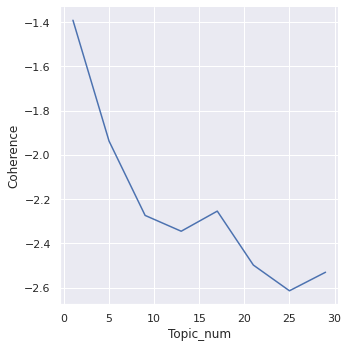

In [11]:
#Coherence Score Graphing
coherence_scores = pd.DataFrame(lda_umass_scores, 
                                columns = ['Topic_num',
                                           'Coherence'])

sns.relplot(data = coherence_scores, 
            kind="line",
            x = 'Topic_num', 
            y= 'Coherence')

### Run LDA
Using the cleaned data, run the LDA model on the summary tokens.
- Set dictionary as the tokens,
- Filter Extremes
- Set Corpus with Doc2bow
- Create LDA Model with Parameters

### Check Summaries
Let's take a look at how well the text parsing and tokenization worked

In [12]:
#Sample Summaries
sample_item = workplan_df.sample(1)

print(sample_item["Summary"].iloc[0])

print(sample_item["summary_tokenized"].iloc[0])

Dual-eligible beneficiaries are enrolled in Medicaid but qualify for prescription drug coverage under Medicare Part D.  As long as Part D plans meet certain limitations outlined in 42 CFR § 423.120, Part D plan sponsors have discretion to include different Part D drugs and drug utilization tools in their formularies.  We will review the extent to which drug formularies developed by Part D plan sponsors include drugs commonly used by dual-eligible beneficiaries as required.  The Affordable Care Act, § 3313, requires OIG to conduct this review annually.
['dual', 'eligible', 'beneficiar', 'enrolled', 'medicaid', 'qualify', 'prescription', 'drug', 'coverage', 'medicare', 'part', 'long', 'part', 'plan', 'meet', 'certain', 'limitation', 'outlined', '42', 'cfr', '423', '120', 'part', 'plan', 'sponsor', 'discretion', 'include', 'different', 'part', 'drug', 'drug', 'utilization', 'tool', 'formular', 'review', 'extent', 'drug', 'formular', 'developed', 'part', 'plan', 'sponsor', 'include', 'drug

### LDA: Visualize and View Topics
*Use PyLDAvis to generate a visualization of the model*

#### Side Note: We may encounter the word 'Part' often in the data.

#### What are the 'parts' of medicare?
- https://www.medicareinteractive.org/get-answers/medicare-basics/medicare-coverage-overview/original-medicare
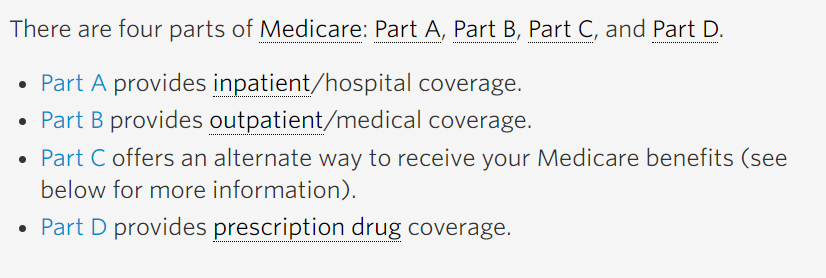

In [13]:
#Visualize the model with pyLDAvis
lda_model_visualize = pyLDAvis.gensim_models.prepare(lda_model,
                                                     corpus = corpus, 
                                                     dictionary = dictionary)
lda_model_visualize

#Give context and explanation for the lambda relevance metric

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23    -0.149675  0.128232       1        1  7.756870
18     0.161191 -0.071851       2        1  7.594740
21    -0.145288  0.053350       3        1  5.879448
28    -0.023293  0.073335       4        1  5.620017
1      0.114251 -0.057311       5        1  5.462133
25     0.090151 -0.009424       6        1  5.118494
7     -0.020519  0.065462       7        1  4.680580
4      0.058920  0.039792       8        1  4.594594
17     0.053818 -0.106595       9        1  3.950033
27     0.132360  0.073101      10        1  3.508386
3     -0.010049 -0.084536      11        1  3.271030
13    -0.206135 -0.129460      12        1  3.270122
6      0.067284  0.031523      13        1  3.160756
5      0.122325 -0.001994      14        1  3.140086
16    -0.094846 -0.077933      15        1  3.104615
8     -0.126422  0.010232      16        1  3.082861
19     0.187496 -0.038262      17        1  2.973717
24    -0.069511 -0.074987      18        1  2.789679
20     0.070051  0.009813      19        1  2.788842
26     0.129000 -0.056905      20        1  2.391018
22    -0.240960 -0.049163      21        1  2.352781
9      0.013698 -0.175325      22        1  2.224261
14     0.111843  0.052477      23        1  2.182472
10    -0.174835  0.043991      24        1  2.044211
15     0.018451  0.217156      25        1  1.718726
12     0.033368  0.067515      26        1  1.674982
2      0.060870  0.048694      27        1  1.432177
0     -0.084209 -0.094873      28        1  1.216130
11    -0.079335  0.113945      29        1  1.016240, topic_info=          Term        Freq       Total Category  logprob  loglift
161       drug  432.000000  432.000000  Default  30.0000  30.0000
235   medicare  938.000000  938.000000  Default  29.0000  29.0000
41       state  749.000000  749.000000  Default  28.0000  28.0000
80        care  624.000000  624.000000  Default  27.0000  27.0000
300       part  358.000000  358.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
216   provider    7.685514  310.905873  Topic29  -4.1263   0.8889
350  physician    5.048907  112.392887  Topic29  -4.5464   1.4862
71      review    6.766224  432.647417  Topic29  -4.2537   0.4311
347   hospital    6.101897  299.064897  Topic29  -4.3570   0.6970
211    payment    5.713487  629.703671  Topic29  -4.4228  -0.1134

[1559 rows x 6 columns], token_table=      Topic      Freq Term
term                      
46        2  0.160082  000
46        5  0.022869  000
46        9  0.068606  000
46       11  0.114344  000
46       13  0.045738  000
...     ...       ...  ...
650       3  0.050110    ½
650       4  0.050110    ½
650       9  0.150329    ½
650      12  0.100219    ½
650      19  0.300658    ½

[6810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 19, 22, 29, 2, 26, 8, 5, 18, 28, 4, 14, 7, 6, 17, 9, 20, 25, 21, 27, 23, 10, 15, 11, 16, 13, 3, 1, 12])

Relevance is 

In [14]:
#Topics Generated
for idx, topic in lda_model.print_topics():
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 13 
Words: 0.040*"medicare" + 0.035*"price" + 0.034*"amount" + 0.027*"drug" + 0.026*"reimbursement" + 0.022*"part" + 0.018*"average" + 0.018*"data" + 0.017*"quarter" + 0.016*"previou"
Topic: 24 
Words: 0.086*"opioid" + 0.038*"overdose" + 0.034*"beneficiar" + 0.032*"death" + 0.019*"risk" + 0.019*"identify" + 0.019*"000" + 0.018*"state" + 0.018*"crisi" + 0.016*"medicare"
Topic: 19 
Words: 0.060*"children" + 0.036*"orr" + 0.029*"program" + 0.026*"unaccompanied" + 0.020*"health" + 0.019*"acf" + 0.017*"office" + 0.015*"federal" + 0.015*"famil" + 0.014*"provide"
Topic: 20 
Words: 0.047*"children" + 0.040*"care" + 0.027*"state" + 0.022*"foster" + 0.015*"health" + 0.014*"contract" + 0.013*"claim" + 0.013*"telehealth" + 0.012*"data" + 0.012*"identify"
Topic: 18 
Words: 0.033*"health" + 0.023*"fund" + 0.022*"grant" + 0.019*"response" + 0.017*"cdc" + 0.017*"control" + 0.013*"program" + 0.013*"preparednes" + 0.012*"public" + 0.012*"federal"
Topic: 28 
Words: 0.072*"medicaid" + 0.049*"state"

In [15]:
#Eye Test (Classification Test)
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'], end = '')

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

Each year, statutorily mandated rebates enable Medicaid to recoup a substantial portion of the billions spent by the program on prescription drugs.  In contrast, Medicare Part B also spends billions annually on prescription drugs; however, no similar rebate authority exists for Part B to reduce the costs of drugs to the program.  OIG will examine the amount the Federal Government could potentially collect from pharmaceutical manufacturers if inflation-indexed rebates were required under Medicare Part B, which builds upon earlier OIG work examining existing inflation-based rebates in Medicaid and potential rebates in Medicare Part B.  The study will select a sample of 50-100 Part B drugs.  We will calculate the amount covering the difference between the existing rebate policy in 2015 and a scenario where an inflation-based rebate methodology similar to Medicaid had been in place for drugs covered under Medicare Part B and in absence of industry adjustments to such rebate agreement.
Scor

-- Plot here for u_mass coherence based on topics

## BERTopic Topic Modeling
*BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. BERTopic supports guided, (semi-) supervised, and dynamic topic modeling. (MaartgenGr)* 

#### Repo
- https://github.com/MaartenGr/BERTopic

#### Papers
- https://arxiv.org/pdf/2203.05794.pdf
- https://arxiv.org/pdf/2107.02173.pdf

- https://hackernoon.com/nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

#### On removing stopwords:
- https://stackoverflow.com/questions/68127754/removal-of-stop-words-and-stemming-lemmatization-for-bertopic#:~:text=In%20conclusion%2C%20the%20BERTTopic%20does,both%20processing%20time%20and%20results.

#### On Lemmatization
- https://github.com/MaartenGr/BERTopic/issues/286


## Step 1: Clean data before model usage
- Add lemmatization
- Set documents for BERTopic as 'docs'
- Use vectorizer_model and set parameters

In [16]:
#CountVectorizer is used here for removing stopwords after processing
from sklearn.feature_extraction.text import CountVectorizer   
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

#Remove Stopwords through vectorizer_model
from bertopic import BERTopic

#Lemmatizer for cleaning text
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#Set docs as workplan summaries
docs = workplan_df["Summary"]

#Vectorizer model for adding in Stopwords and Lemmatization
vectorizer_model = CountVectorizer(ngram_range=(1, 2), 
                                   stop_words=stopwords,
                                   tokenizer=LemmaTokenizer())

## Step 2: Run BERTopic Model
- Use vectorizer model
- Fit and return topics and probabilites

In [17]:
#Bert Model- use countvectorizer, allow n-grams of size 1 or 2
bert_model = BERTopic(vectorizer_model=vectorizer_model, 
                      top_n_words = 10,
                      n_gram_range=(1, 2),
                      language = 'english')

#Fit/Transform Topics and Probabilities
topics, probabilities = bert_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [18]:
#Display Topics
bert_model.get_topic_info()

,Topic,Count,Name
0,-1,86,-1_medicare_payment_service_care
1,0,141,0_covid19_health_audit_federal
2,1,85,1_medicare_payment_hospital_service
3,2,71,2_state_medicaid_care_service
4,3,70,3_drug_part_medicare_manufacturer
5,4,41,4_opioid_treatment_overdose_abuse
6,5,32,5_child_state_family_program
7,6,22,6_nih_institute_research_national institute
8,7,22,7_mfcus_medicaid_fraud_data
9,8,20,8_child_orr_unaccompanied_unaccompanied child


Display depth of topics:

In [19]:
#Display Topics (top-5)
pd.DataFrame(bert_model.get_topics()).T.loc[0::]

,0,1,2,3,4,5,6,7,8,9
0,"(covid19, 0.021030983238448486)","(health, 0.019133126277137796)","(audit, 0.01675770967638882)","(federal, 0.016288907390645375)","(control, 0.015969558589793747)","(fund, 0.014242281584061043)","(program, 0.014044779763816654)","(financial, 0.013583758663884945)","(agency, 0.01353379515117799)","(act, 0.013187532173710815)"
1,"(medicare, 0.04758660560959287)","(payment, 0.037708019098909216)","(hospital, 0.036045986978224594)","(service, 0.034468438228640506)","(claim, 0.023295466383489047)","(inpatient, 0.022692687907291547)","(beneficiary, 0.01862993814906306)","(physician, 0.017771924270279807)","(determine, 0.016221485542547695)","(part, 0.015103346150302486)"
2,"(state, 0.0561395759288275)","(medicaid, 0.04767917135257937)","(care, 0.03013875199438857)","(service, 0.028940947089849074)","(federal, 0.024697588167257676)","(managed care, 0.020662104247360234)","(managed, 0.02034377806528445)","(payment, 0.019772751840829085)","(health, 0.017658670405398036)","(mcos, 0.01748976051098837)"
3,"(drug, 0.07335256350920519)","(part, 0.04086653462256527)","(medicare, 0.03348923568632553)","(manufacturer, 0.029481638088981174)","(price, 0.02890546432119588)","(rebate, 0.027993126768729573)","(amount, 0.022020773845700614)","(beneficiary, 0.019628125138157076)","(medicaid, 0.01951249408176607)","(medicare part, 0.017801782077638356)"
4,"(opioid, 0.06893209140194435)","(treatment, 0.034674606683401575)","(overdose, 0.033882049442680806)","(abuse, 0.028357359980929087)","(opioids, 0.02702696505954566)","(substance, 0.026673102752748718)","(death, 0.025235887507539953)","(use, 0.024596679476275366)","(disorder, 0.024409949000377264)","(health, 0.02247631645509735)"
5,"(child, 0.05573811806861047)","(state, 0.05319519758895391)","(family, 0.03617613365433672)","(program, 0.033783690966025036)","(check, 0.029801313848276313)","(care, 0.027383394238075908)","(foster, 0.02711308868302753)","(childcare, 0.02680544661627329)","(foster care, 0.02530398692692492)","(background, 0.02372775378594924)"
6,"(nih, 0.10138502341209599)","(institute, 0.05097786602938653)","(research, 0.04572530747530379)","(national institute, 0.035924515103469896)","(grant, 0.034100487941188404)","(grantee, 0.03160647459050338)","(institute health, 0.030604773405145377)","(national, 0.029639649409684877)","(health, 0.027596358191331997)","(foreign, 0.026779176729502207)"
7,"(mfcus, 0.0757319283196049)","(medicaid, 0.0594158053934018)","(fraud, 0.0513152640060818)","(data, 0.03219938323062004)","(state, 0.03192052565921414)","(mfcu, 0.028693708755903394)","(abuse, 0.026913456509902286)","(report, 0.023112623485654696)","(provides, 0.022332556658386626)","(state medicaid, 0.021087027372969816)"
8,"(child, 0.08283587530263209)","(orr, 0.08117652819520418)","(unaccompanied, 0.05351399337365185)","(unaccompanied child, 0.041480009919528264)","(refugee, 0.041480009919528264)","(facility, 0.03903458241292896)","(resettlement, 0.030895459757846834)","(refugee resettlement, 0.030895459757846834)","(resettlement orr, 0.029666641437327886)","(office refugee, 0.029666641437327886)"
9,"(ihs, 0.09606348486300242)","(indian, 0.06005245907136549)","(health, 0.049534639532693533)","(indian health, 0.03372802177308923)","(health service, 0.03127648344376823)","(service, 0.030513301605268457)","(facility, 0.02926682509578147)","(tribal, 0.02862308140082008)","(program, 0.026039733909661304)","(service ihs, 0.025571072135179354)"


In [20]:
#Eye Test:
random_doc = random.randint(0,len(docs))
print(docs[random_doc])

model_prediction = bert_model.transform(docs[random_doc])
print(model_prediction)

bert_model.get_topic(topic=model_prediction[0][0])

When Congress established average sales price (ASP) as the basis for Medicare Part B drug reimbursement, it also provided a mechanism for monitoring market prices and limiting potentially excessive Medicare payment amounts.  The Social Security Act mandates that the OIG compare ASPs with average manufacturer prices (AMPs).  If OIG finds that the ASP for a drug exceeds the AMP by 5 percent in the two previous quarters or three of the previous four quarters, the Secretary of Health and Human Services may substitute the reimbursement amount with a lower calculated rate.  This quarterly memo summarizes the results of OIGs comparison analysis based on ASP and AMP data reported for the first quarter of 2020.  The memo specifically reports the number of drugs OIG identified that met the criteria for substitution of a lower reimbursement amount.
([3], array([0.91810042]))


[('drug', 0.07335256350920519),
 ('part', 0.04086653462256527),
 ('medicare', 0.03348923568632553),
 ('manufacturer', 0.029481638088981174),
 ('price', 0.02890546432119588),
 ('rebate', 0.027993126768729573),
 ('amount', 0.022020773845700614),
 ('beneficiary', 0.019628125138157076),
 ('medicaid', 0.01951249408176607),
 ('medicare part', 0.017801782077638356)]

### BERTopic Visualizations
- Visualizations of topics

In [32]:
bert_model.visualize_barchart(n_words = 7,
                              width=400, 
                              height=400,
                              top_n_topics = 10)

In [22]:
bert_model.visualize_topics()

In [23]:
bert_model.visualize_heatmap()

## Comparing the two models:

In [24]:
#Comparison between models
n = random.randint(0,len(workplan_df))

print(workplan_df.iloc[n]['Summary'])

#############
#LDA Model  #
#############
print("***LDA Model***")

for index, score in sorted(lda_model[corpus[n]], key=lambda tup: -1*tup[1]):

    print(score, lda_model.print_topic(index, 10))

#############
#Bert Model #
#############
print("\n***Bert Model***")
model_prediction = bert_model.transform(docs[n])

print(f"BERT: {model_prediction}")

bert_model.get_topic(topic=model_prediction[0][0])

Several State Medicaid agencies retain consultants to assist with preparing Medicaid claims for school-based activities.
	Consultants often are paid a contingency fee based on the percentage of Federal funds reimbursed to the State. During a prior
	review, we found that one consultant developed unsupported timestudies that it used to develop payment rates for school-based
	health services. Based on those rates, the State claimed unallowable Federal funds. Consultants developed timestudies using
	a similar methodology in many other States. We will initiate a multiple State review with a roll-up report to CMS to determine
	whether consultants developed school-based Medicaid rates based on unsupported timestudies and unallowable costs in these
	States
***LDA Model***
0.5861833 0.043*"medicare" + 0.033*"medicaid" + 0.026*"provider" + 0.023*"state" + 0.023*"home" + 0.020*"health" + 0.017*"program" + 0.016*"payment" + 0.014*"care" + 0.011*"cost"
0.39855385 0.023*"report" + 0.023*"program" + 

[('state', 0.0561395759288275),
 ('medicaid', 0.04767917135257937),
 ('care', 0.03013875199438857),
 ('service', 0.028940947089849074),
 ('federal', 0.024697588167257676),
 ('managed care', 0.020662104247360234),
 ('managed', 0.02034377806528445),
 ('payment', 0.019772751840829085),
 ('health', 0.017658670405398036),
 ('mcos', 0.01748976051098837)]

In [25]:
model_prediction

([2], array([0.52687007]))

### References
Link: https://zbib.org/d7adbbe5aea84033ae5c3d470692299b
  
  
### Works Cited
Kapadia, Shashank. “Topic Modeling in Python: Latent Dirichlet Allocation (LDA).” Medium, 29 Dec. 2020, https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0.

Kelechava, Marc. “Using LDA Topic Models as a Classification Model Input.” Medium, 6 Aug. 2020, https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28.

Khalid, Irfan Alghani. “Implement Your Topic Modeling Using The BERTopic Library.” Medium, 25 Jan. 2022, https://towardsdatascience.com/implement-your-topic-modeling-using-the-bertopic-library-d6708baa78fe.

“PyLDAvis: Topic Modelling Exploration Tool That Every NLP Data Scientist Should Know.” Neptune.Ai, 16 Nov. 2020, https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know.

Yadav, Kajal. “The Complete Practical Guide to Topic Modelling.” Medium, 22 Jan. 2022, https://towardsdatascience.com/topic-modelling-f51e5ebfb40a.
